# Forward modeling of the emission spectrum using Fe I line list from Kurucz

Tako Ishikawa  
last update: 2022/04/25   
created: : 2022/04/22  

In [2]:
from exojax.spec.rtransfer import nugrid
from exojax.spec.rtransfer import pressure_layer
from exojax.spec import moldb, molinfo, contdb
from exojax.spec import atomll
from exojax.spec.exomol import gamma_exomol
from exojax.spec import SijT, doppler_sigma
from exojax.spec import planck
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap, jit
import numpy as np
from exojax.spec.initspec import init_lpf
from exojax.spec.rtransfer import dtauCIA, dtauHminus
from exojax.spec.lpf import xsmatrix
from exojax.spec.rtransfer import dtauM

T-P profile 

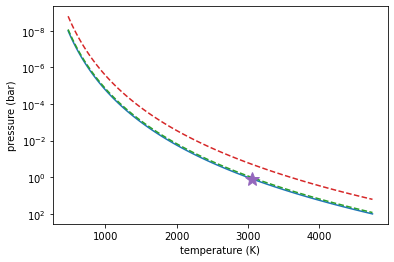

In [3]:
#Assume ATMOSPHERE
NP=100
T0=3000. #10000. #3000. #1295.0 #K
Parr, dParr, k=pressure_layer(NP=NP)
H_He_HH_VMR = [0.0, 0.16, 0.84] #typical quasi-"solar-fraction"
Tarr = T0*(Parr)**0.1

mmw=2.33 #mean molecular weight

PH = Parr* H_He_HH_VMR[0]
PHe = Parr* H_He_HH_VMR[1]
PHH = Parr* H_He_HH_VMR[2]

fig=plt.figure(figsize=(6,4))
plt.plot(Tarr,Parr)
plt.plot(Tarr, PH, '--'); plt.plot(Tarr, PHH, '--'); plt.plot(Tarr, PHe, '--')
plt.plot(Tarr[80],Parr[80], marker='*', markersize=15)
plt.yscale("log")
plt.xlabel("temperature (K)")
plt.ylabel("pressure (bar)")
plt.gca().invert_yaxis()
plt.show()


Wavenumber

In [4]:
wls,wll = 10350, 10450
nugrid_res = 0.01
nus, wav, reso = nugrid(wls, wll, int((wll-wls)/nugrid_res), unit="AA", xsmode="lpf")

xsmode assumes ESLOG: mode= lpf


Load a Kurucz line list for neutral iron (Fe I)  
(Downloaded from [Index of /linelists/gfall](http://kurucz.harvard.edu/linelists/gfall/))

In [5]:
"""
    kuruczlines:  fullpath to the input line list obtained from Kurucz linelists (http://kurucz.harvard.edu/linelists/):
        For a example in this notebook, gf2600.all downloaded from (http://kurucz.harvard.edu/linelists/gfall/) is used.
"""

kuruczlines = '/home/tako/work/VALD3/gf2600.all'
adbK = moldb.AdbKurucz(kuruczlines, nus)

Reading Kurucz file


Relative partition function

In [6]:
#Computing the relative partition function,

qt_284=vmap(adbK.QT_interp_284)(Tarr)

qt_K = np.zeros([len(adbK.QTmask), len(Tarr)])
for i, mask in enumerate(adbK.QTmask):
    qt_K[i] = qt_284[:,mask]  #e.g., qt_284[:,76] #Fe I
qt_K = jnp.array(qt_K)

Lorentzian width, Doppler width, and Line strength

In [7]:
gammaLM_K = jit(vmap(atomll.gamma_vald3,(0,0,0,0,None,None,None,None,None,None,None,None,None,None,None)))\
        (Tarr, PH, PHH, PHe, adbK.ielem, adbK.iion, \
                adbK.dev_nu_lines, adbK.elower, adbK.eupper, adbK.atomicmass, adbK.ionE, \
                adbK.gamRad, adbK.gamSta, adbK.vdWdamp, 1.0)

sigmaDM_K = jit(vmap(doppler_sigma,(None,0,None)))\
    (adbK.nu_lines, Tarr, adbK.atomicmass)

SijM_K = jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr, adbK.logsij0, adbK.nu_lines, adbK.elower, qt_K.T)

Initialization of LPF.

In [8]:
numatrix_K = init_lpf(adbK.nu_lines, nus)

Stellar parameters

In [9]:
#Parameters of Objects
Rp = 0.36*10 #R_sun*10
Mp = 0.37*1e3 #M_sun*1e3
g = 2478.57730044555*Mp/Rp**2
print('logg: '+str(np.log10(g)))

logg: 4.849799190511717


Volume mixing ratio of Fe (applying the Solar value)

In [10]:
VMR_Fe = atomll.get_VMR_uspecies(np.array([[26,1]]))

Cross section and delta tau

In [11]:
xsm_K = xsmatrix(numatrix_K, sigmaDM_K, gammaLM_K, SijM_K)
dtaua_K = dtauM(dParr, xsm_K, VMR_Fe*np.ones_like(Tarr), mmw, g)

Delta tau for CIA and Hminus

In [12]:
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia', nus)

vmrh=H_He_HH_VMR[0]
vmre=vmrh*1e-5
vmrH2=H_He_HH_VMR[2] #(0.74*mmw/molinfo.molmass("H2")) #VMR

dtau_Hm = dtauHminus(nus, Tarr, Parr, dParr, vmre, vmrh, mmw, g)
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)


H2-H2


Total dtau

In [13]:
dtau_K = dtaua_K + dtau_Hm + dtaucH2H2

Contribution function using exojax.plot.atmplot 

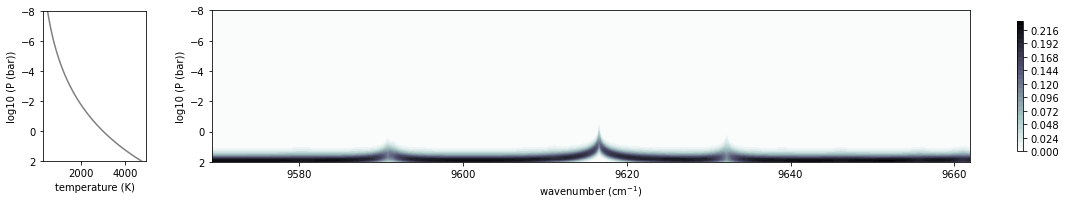

In [14]:
from exojax.plot.atmplot import plotcf
plotcf(nus, dtau_K, Tarr, Parr, dParr)
#plt.savefig(path_fig + 'dtau_K.pdf')
plt.show()

Perform a radiative transfer. Here, the source function is the Planck function (multiplied by pi).

In [15]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr, nus)

F0_K = rtrun(dtau_K, sourcef)

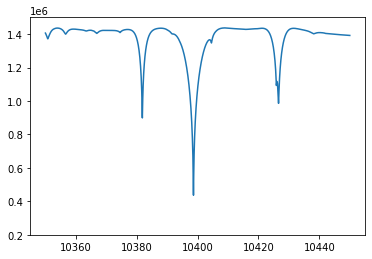

In [16]:
plt.plot(wav[::-1], F0_K)
plt.ylim(0.2e6, 1.5e6)
#plt.savefig(path_fig + 'F0_K.pdf')
plt.show()

# Comparison with Fe I lines of VALD3
(c.f. [Forward modeling of the emission spectrum using VALD3](http://secondearths.sakura.ne.jp/exojax/tutorials/metals.html))

In [17]:
"""
    valdlines:  fullpath to the input line list obtained from VALD3 (http://vald.astro.uu.se/):
        For a example in this notebook, the VALD3 request form of "Extract Element" mode was used filling the form "Element [ + ionization ] :" with "Fe 1".
        For more details of VALD data access, please see "Forward modeling for metal line.ipynb" (https://github.com/HajimeKawahara/exojax/blob/master/examples/tutorial/Forward%20modeling%20for%20metal%20line.ipynb)
"""

valdlines = '/home/tako/work/VALD3/vald2600.gz'
adbV = moldb.AdbVald(valdlines, nus)

Reading VALD file


In [18]:
qt_V = np.zeros([len(adbV.QTmask), len(Tarr)])

for i, mask in enumerate(adbV.QTmask):
    qt_V[i] = qt_284[:,mask]
qt_V = jnp.array(qt_V)

gammaLM_V = jit(vmap(atomll.gamma_vald3,(0,0,0,0,None,None,None,None,None,None,None,None,None,None,None)))\
        (Tarr, PH, PHH, PHe, adbV.ielem, adbV.iion, \
                adbV.dev_nu_lines, adbV.elower, adbV.eupper, adbV.atomicmass, adbV.ionE, \
                adbV.gamRad, adbV.gamSta, adbV.vdWdamp, 1.0)
sigmaDM_V = jit(vmap(doppler_sigma,(None,0,None)))\
    (adbV.nu_lines, Tarr, adbV.atomicmass)
SijM_V = jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr, adbV.logsij0, adbV.nu_lines, adbV.elower, qt_V.T)

numatrix_V = init_lpf(adbV.nu_lines, nus)

xsm_V = xsmatrix(numatrix_V, sigmaDM_V, gammaLM_V, SijM_V)
dtaua_V = dtauM(dParr, xsm_V, VMR_Fe*np.ones_like(Tarr), mmw, g)
dtau_V = dtaua_V + dtau_Hm + dtaucH2H2


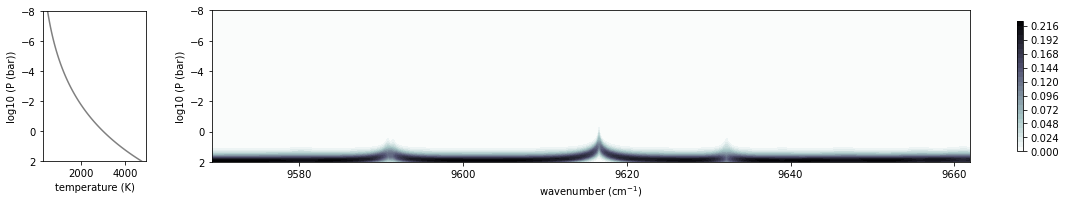

In [20]:
from exojax.plot.atmplot import plotcf
plotcf(nus, dtau_V, Tarr, Parr, dParr)
#plt.savefig(path_fig + 'dtau_V.pdf')
plt.show()

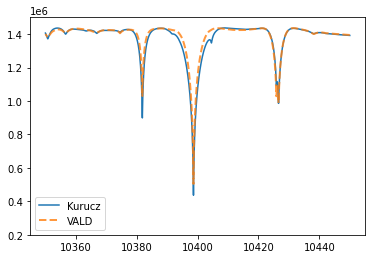

In [25]:
F0_V = rtrun(dtau_V, sourcef)

plt.plot(wav[::-1], F0_K, label='Kurucz')
plt.plot(wav[::-1], F0_V, '--', label='VALD', lw=2., alpha=.8)
plt.ylim(0.2e6, 1.5e6)
plt.legend()
#plt.savefig(path_fig + 'comp_F0_KV.pdf')
plt.show()

In [36]:
#Comparison of values
print(1e8/adbK.nu_lines[np.argmax(adbK.logsij0)],  1e8/adbV.nu_lines[np.argmax(adbV.logsij0[20:])+20])
print(adbK.elower[np.argmax(adbK.logsij0)],  adbV.elower[np.argmax(adbV.logsij0[20:])+20])
print(adbK.logsij0[np.argmax(adbK.logsij0)],  adbV.logsij0[np.argmax(adbV.logsij0[20:])+20])
print(adbK.A[np.argmax(adbK.logsij0)],  adbV.A[np.argmax(adbV.logsij0[20:])+20])
print(adbK.vdWdamp[np.argmax(adbK.logsij0)],  adbV.vdWdamp[np.argmax(adbV.logsij0[20:])+20])

10398.644993873695 10398.6434
17550.18 17549.809
-122.76289 -123.187065
4245.6694 2772.9773
-7.76 -7.8
